#Self attention in transformers


#Generate Data

In [1]:
import numpy as np
import math

L, d_k, d_v = 4, 8, 8

q = np.random.randn(L,d_k)
k = np.random.randn(L,d_k)
v = np.random.randn(L,d_v)
print("Q\n",q)
print("K\n",k)
print("V\n",v)

Q
 [[ 0.61309447  0.91506437  0.17928648 -0.27264527  0.19815865 -0.02763374
   0.30879337  0.27903206]
 [ 2.69379771 -0.23551054  1.32126455 -0.74207261  0.58136525  0.69722202
  -0.71070405  0.10600109]
 [-1.09163064 -0.69622594 -0.05637154  0.19256647 -0.45691985  1.02455255
  -1.55772857  0.49051046]
 [ 1.11384231  0.53439112  0.02576718  0.2703154  -0.89751473 -0.09377303
   0.55149566 -0.85294598]]
K
 [[-1.73103395 -0.25666761 -0.91997805 -0.77270287 -0.35118486  0.51912348
  -0.13213558 -1.92365178]
 [-0.85227627  1.12124783  1.10568746 -1.56074242 -0.87117527  0.03346966
  -0.51450005 -0.33870361]
 [-0.24157953 -0.11136578 -1.33738659  0.25303467  0.19797067 -0.77156918
   0.55320392  0.81339493]
 [ 0.94791864 -0.37336424  0.29379027  0.0029842   0.36586476  1.11545411
   0.29594558  1.13071325]]
V
 [[ 0.93524188  0.38485664 -0.54203671 -1.17671975 -0.92106956  0.04904538
   0.69986602  1.13725061]
 [-0.87886758  0.31937379 -0.62532131  0.04615786  0.99873222 -0.15069474
  -0.7

This code generates random matrices Q, K, and V, which are typically used in the context of the scaled dot-product attention mechanism in the Transformer model. Let's break down the code:

Here's what each part does:

L: Number of attention heads (or queries, keys, values).

d_k: Dimensionality of the keys and queries.

d_v: Dimensionality of the values.

The code then generates random matrices for Q (queries), K (keys), and V (values) using NumPy's randn function, which generates an array of random samples from the standard normal distribution.

The resulting matrices q, k, and v have shapes (L, d_k), (L, d_k), and (L, d_v) respectively.

In the Transformer model, these matrices are used in the attention mechanism to compute attention scores, which are then used to weight the values (v) to obtain the weighted sum, representing the attended information.

#Self Attention

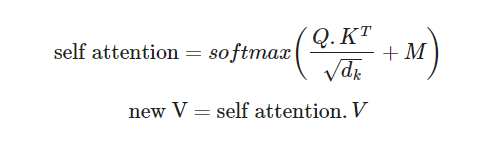

In [2]:
np.matmul(q, k.T)

array([[-1.91191933,  0.70031274, -0.10044207,  0.73993674],
       [-5.19696234, -0.09421663, -3.30915542,  3.92733978],
       [ 1.92600493,  0.85451556, -0.87836483,  0.27847637],
       [-0.46342581,  0.04038667, -0.78867748, -0.36950697]])

By using the scaled dot product (dividing by
�
�
d
k
​

​
 ), we aim to keep the variances of these quantities within a more stable range during the training process.

In [3]:
# Why we need sqrt(d_k) in denominator
q.var(), k.var(), np.matmul(q, k.T).var()

(0.6551147955866536, 0.6941088909749681, 3.9381294403548246)

In [4]:
scaled = np.matmul(q, k.T) / math.sqrt(d_k)
q.var(), k.var(), scaled.var()

(0.6551147955866536, 0.6941088909749681, 0.4922661800443529)

#Masking
This is to ensure words don't get context from words generated in the future.
Not required in the encoders, but required int he decoders

The code creates a lower triangular matrix (mask) filled with ones and the rest of the elements set to zero. This matrix is commonly used as a mask in the context of the Transformer model, particularly for preventing attention to future tokens in a sequence during self-attention.

np.ones((L, L)): Creates a square matrix of size
�
×
�
L×L filled with ones.

np.tril(...): Takes the lower triangular part of the matrix and sets the upper triangular part to zero. The resulting matrix is a lower triangular matrix with ones on and below the main diagonal.

The purpose of this mask in the Transformer model is to prevent positions (tokens) in the input sequence from attending to positions after them during self-attention. In other words, it enforces causal attention. The lower triangular matrix ensures that each position can attend to positions up to and including itself but not to positions after itself in the sequence.

In the context of self-attention, this mask will be applied to the scaled dot-product attention scores to zero out (mask) the attention weights for positions after the current position, ensuring that each position attends only to positions before it.

In [12]:
mask = np.tril(np.ones((L, L)))
mask

array([[1., 0., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 1., 0.],
       [1., 1., 1., 1.]])

In [13]:
mask[mask == 0] = -np.infty
mask[mask == 1] = 0
mask


array([[  0., -inf, -inf, -inf],
       [  0.,   0., -inf, -inf],
       [  0.,   0.,   0., -inf],
       [  0.,   0.,   0.,   0.]])

In [14]:
scaled + mask

array([[-0.67596556,        -inf,        -inf,        -inf],
       [-1.83740366, -0.03331061,        -inf,        -inf],
       [ 0.68094557,  0.30211687, -0.31054886,        -inf],
       [-0.16384577,  0.01427884, -0.2788396 , -0.13064044]])

#Soft Max

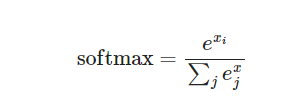

In [16]:
def softmax(x):
  return (np.exp(x).T / np.sum(np.exp(x), axis = -1)).T

In [18]:
attention = softmax(scaled + mask)
attention

array([[1.        , 0.        , 0.        , 0.        ],
       [0.14135355, 0.85864645, 0.        , 0.        ],
       [0.48645593, 0.33305832, 0.18048576, 0.        ],
       [0.24271205, 0.29003464, 0.21634664, 0.25090668]])

In [19]:
new_v = np.matmul(attention,v)
new_v

array([[ 0.93524188,  0.38485664, -0.54203671, -1.17671975, -0.92106956,
         0.04904538,  0.69986602,  1.13725061],
       [-0.62243677,  0.32863002, -0.61354874, -0.12670023,  0.72736142,
        -0.12246076, -0.52599394, -0.39595786],
       [ 0.14394965,  0.617539  , -0.49557498, -0.81130906,  0.23568215,
        -0.24735004,  0.19264976,  0.51032515],
       [-0.38201731,  0.77037338, -0.78435298, -0.18493989,  0.53913527,
        -0.34687095,  0.42771487,  0.31868722]])

In [20]:
v

array([[ 0.93524188,  0.38485664, -0.54203671, -1.17671975, -0.92106956,
         0.04904538,  0.69986602,  1.13725061],
       [-0.87886758,  0.31937379, -0.62532131,  0.04615786,  0.99873222,
        -0.15069474, -0.72779954, -0.6483603 ],
       [-0.10133848,  1.7948957 , -0.13092193, -1.40875396,  1.94533812,
        -1.22457486,  0.52411603,  0.95877175],
       [-1.32394043,  0.78122642, -1.7660143 ,  1.56255693,  0.20786871,
        -0.19981738,  1.41704197,  0.09279426]])

In [21]:
def scaled_dot_product_attention(q,k,v,mask = None):
  d_k = q.shape[-1]
  scaled = np.matmul(q,k.T)/math.sqrt(d_k)
  if mask is not None:
    scaled = scaled + mask
  attention = softmax(scaled)
  out = np.matmul(attention,v)
  return out,attention


In [23]:
values, attention = scaled_dot_product_attention(q,k,v,mask = None)
print("Q\n",q)
print("K\n",k)
print("V\n",v)
print("New_V \n", values)
print("Attention\n", attention)

Q
 [[ 0.61309447  0.91506437  0.17928648 -0.27264527  0.19815865 -0.02763374
   0.30879337  0.27903206]
 [ 2.69379771 -0.23551054  1.32126455 -0.74207261  0.58136525  0.69722202
  -0.71070405  0.10600109]
 [-1.09163064 -0.69622594 -0.05637154  0.19256647 -0.45691985  1.02455255
  -1.55772857  0.49051046]
 [ 1.11384231  0.53439112  0.02576718  0.2703154  -0.89751473 -0.09377303
   0.55149566 -0.85294598]]
K
 [[-1.73103395 -0.25666761 -0.91997805 -0.77270287 -0.35118486  0.51912348
  -0.13213558 -1.92365178]
 [-0.85227627  1.12124783  1.10568746 -1.56074242 -0.87117527  0.03346966
  -0.51450005 -0.33870361]
 [-0.24157953 -0.11136578 -1.33738659  0.25303467  0.19797067 -0.77156918
   0.55320392  0.81339493]
 [ 0.94791864 -0.37336424  0.29379027  0.0029842   0.36586476  1.11545411
   0.29594558  1.13071325]]
V
 [[ 0.93524188  0.38485664 -0.54203671 -1.17671975 -0.92106956  0.04904538
   0.69986602  1.13725061]
 [-0.87886758  0.31937379 -0.62532131  0.04615786  0.99873222 -0.15069474
  -0.7